<a href="https://colab.research.google.com/github/bkhalf/IMDB-movie-review-dataset-classification/blob/main/Classical_Machine_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Data

In [ ]:
# dowenload the data
!wget -cq https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
import tarfile
tar = tarfile.open("aclImdb_v1.tar.gz")
tar.extractall()
tar.close()
!rm -r aclImdb_v1.tar.gz

#Download Model

In [ ]:
# download the word vector
!pip install --upgrade gensim;
!wget -cq https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip;
!unzip wiki-news-300d-1M.vec.zip;
!rm -r wiki-news-300d-1M.vec.zip;

# Import Libraries 

In [ ]:
import numpy as np
import pandas as pd
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import os
import re
import io
from gensim.models import Word2Vec,KeyedVectors,doc2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse as sps
# import gensim.downloader as api

# Load Data from folders

In [ ]:
# load trainnig and Test data
def load_from_dir(sub_path):
  path = sub_path+"/pos"
  os.chdir(path)
  data = []
  def read_text_file(file_path ):
      with open(file_path, 'r') as f:
          return f.read()
    
  # iterate through all file
  for file in os.listdir():
      # Check whether file is in text format or not
      if file.endswith(".txt"):
          file_path = file
          # file_path = f"{path}\{file}"
    
          # call read text file function
          temp = read_text_file(file_path)
          data.append([temp, (1)])
  # load negative trainnig data
  path = sub_path+"/neg"
  os.chdir(path)
    
  # iterate through all file
  for file in os.listdir():
      # Check whether file is in text format or not
      if file.endswith(".txt"):
          file_path = file
          # file_path = f"{path}\{file}"
    
          # call read text file function
          temp = read_text_file(file_path)
          data.append([temp, (0)])

  os.chdir("/content/")
  return pd.DataFrame (data, columns = ['review','class'])


In [ ]:
# take 10% from the train data to create the validation
def get_validation(df):
  validation = df.sample(frac = .1)
  df = df.drop(validation.index)
  return df, validation

#Text Pre-processing

In [ ]:
#remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

# Stop word removal: 
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['.',',','"','(',')','<','>','[',']','{','}','.',',','/','\\','|','\'ve']
stopwords.extend(newStopWords)
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

# stemming
# def stemming(text):
  # porter_stemmer = nltk.stem.porter.PorterStemmer()
  #   stem_text = [porter_stemmer.stem(word) for word in text]
  #   return stem_text
  
# lemmatization
def lemmatizer(text):
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text


In [ ]:
def preproccessing(data):
  #storing the puntuation free text
  data['review']= data['review'].apply(lambda x:remove_punctuation(x))
  # convert all the txt to lower
  data['review']= data['review'].apply(lambda x: x.lower())
  # Tokenization
  data['review'] = data['review'].apply(lambda x: nltk.word_tokenize(x))
  # Stop word removal: 
  data['review']= data['review'].apply(lambda x:remove_stopwords(x))
  # stemming
  # data['review']=data['review'].apply(lambda x: stemming(x)) 
  # lemmatization
  data['review']=data['review'].apply(lambda x:lemmatizer(x))
  return data


# Load Data in variables

In [ ]:
train = load_from_dir("/content/aclImdb/train")
train_withoutPre = train.copy()
train, val = get_validation(train)
val_withoutPre = val.copy()
train = preproccessing(train)
val = preproccessing(val)

In [ ]:
test = load_from_dir("/content/aclImdb/test")
test_withoutPre = test.copy()
test = preproccessing(test)


# **TF-IDF feature vectorizer methods**

In [ ]:
# change the format to fit in classifiers
def change_format(data):
  x = []
  y = []
  while len(data) != 0:
    # df.iloc[row_start:row_end , col_start, col_end]
    s = " "
    v = data.iloc[ 0, :]
    x.append(s.join(v['review']))
    y.append(v['class'])
    data = data.iloc[1: , :]
  return x, y

In [ ]:
# used to prevent the TfidfVectorizer from preprocess the data 
def preprocess_overwrite(text):
  return text
def tokenizer_overwrite(text):
  return text.split()

In [ ]:
#Vectorize using sklearn 
def vectorize(data):
  vectorizer = TfidfVectorizer(preprocessor = preprocess_overwrite, tokenizer = tokenizer_overwrite)
  response = vectorizer.fit(data)
  # feature_names = vectorizer.get_feature_names_out()
  return response

# **Gensim word embedding methods**

In [ ]:
# convert the data to doc2vec.TaggedDocument to be able to train Dpc2Vec Model
def convert_corpus(data):
  for i,line in enumerate(data):
    yield doc2vec.TaggedDocument(line, [i])


In [ ]:
# change the data type of data from Data frame to two lists
def change_format_embedded(data):
  x = []
  y = []
  while len(data) != 0:
    # df.iloc[row_start:row_end , col_start, col_end]
    v = data.iloc[ 0, :]
    x.append(v['review'])
    y.append(v['class'])
    data = data.iloc[1: , :]
  return x,y
  

In [ ]:
# create Data Matrix
def create_embedded_matrix(lst,cl):
  ans = []
  new_y = []
  while len(lst) != 0:
    t = lst.pop()
    ny = cl.pop()
    ans.append(model.infer_vector(t))
    new_y.append(ny)
      
    
  return ans, new_y

# **Tuning Paramters**

In [ ]:
# tunning on k-nn to choose best K
def knn_tune( x_t,y_t,x_v,y_v):
  max_score = 0
  wanted = 0
  samples = []
  accuracy = []
  test_k = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
  for k in test_k:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k,algorithm='ball_tree')
    knn.fit(x_t, y_t)

    knn_prediction = knn.predict(x_v)
    predict = metrics.accuracy_score(y_v, knn_prediction)
    if predict > max_score :
      max_score = predict 
      wanted = k
    samples.append(k)
    accuracy.append(predict)

  return wanted , samples , accuracy


In [ ]:
# tunning on AdaBoost to choose best n_estimators
def adaBoost_tune(n_estimators, x_t,y_t,x_v,y_v):
  max_score = 0
  wanted = 0
  estimators=[]
  accuracy = []
  for n_estimator in n_estimators:
    AdaBoost_model = AdaBoostClassifier(n_estimators=n_estimator, random_state=0)
    AdaBoost_model.fit(x_t, y_t)
    AdaBoost_predict = AdaBoost_model.predict(x_v)
    predict = metrics.accuracy_score(y_v, AdaBoost_predict)
    if predict > max_score :
      max_score = predict 
      wanted = n_estimator
    estimators.append(n_estimator)
    accuracy.append(predict)
  return wanted , estimators , accuracy

In [ ]:
# # tunning on Logistic Regresiion to choose best itration
# def logisticRegression_tune(max_iters,x_t,y_t,x_v,y_v):
#   max_score = 0
#   wanted = 0
#   for itr in max_iters:
#     Logistic_model = LogisticRegression(random_state=0,max_iter=itr).fit(x_t, y_t)
#     Logistic_predict = Logistic_model.predict(x_v)
#     predict = metrics.accuracy_score(y_v, Logistic_predict)
#     if predict > max_score :
#       max_score = predict 
#       wanted = itr
#   return wanted

In [ ]:
# tunning on Random Forest to choose best depth
def randomForest_tune(max_depths,x_t,y_t,x_v,y_v):
  max_score = 0
  wanted = 0
  samples = []
  accuracy = []
  for depth in max_depths:
    RandomForest_model = RandomForestClassifier(max_depth=depth, random_state=0)
    RandomForest_model.fit(x_t, y_t)
    RandomForest_predict = RandomForest_model.predict(x_v)
    predict = metrics.accuracy_score(y_v, RandomForest_predict)
    if predict > max_score :
      max_score = predict 
      wanted = depth
    samples.append(depth)
    accuracy.append(predict)
  return wanted , samples , accuracy

In [ ]:
# # tunning on Linear SVC to choose best Itr
# def linearSVC_tune(max_iters,x_t,y_t,x_v,y_v):
#   max_score = 0
#   wanted = 0
#   for itr in max_iters:
#     LinearSVC_model = make_pipeline(StandardScaler(with_mean=False),
#                    LinearSVC(random_state=0, tol=1e-5,max_iter=itr))
#     LinearSVC_model.fit(x_t, y_t)
#     LinearSVC_predict = LinearSVC_model.predict(x_v)

#     predict = metrics.accuracy_score(y_v, LinearSVC_predict)
#     if predict > max_score :
#       max_score = predict 
#       wanted = itr
#   return wanted

In [ ]:
def tune_all(x_t,y_t,x_v,y_v):
  estimators = []
  accuracies = []
  k,x,y = knn_tune(x_t,y_t,x_v,y_v);  # best is 48
  estimators.append(x)
  accuracies.append(y)
  no_iterations = [300,400,500,600,700]
  estimator,x,y = adaBoost_tune(no_iterations,x_t,y_t,x_v,y_v);  # best is 500 ## put no_estimators
  estimators.append(x)
  accuracies.append(y)
  max_depths = np.linspace(start=25, stop=76, endpoint=True)
  depth,x,y = randomForest_tune(max_depths,x_t,y_t,x_v,y_v)  #45 ##put depths as a paramter
  estimators.append(x)
  accuracies.append(y)
  return k, estimator, depth , estimators , accuracies

# **Classification Methods**

In [ ]:
# KNeighborsClassifier
def KNeighborsClassifier(k, x_tr,y_tr,x_ts,y_ts):
  knn = neighbors.KNeighborsClassifier(n_neighbors = k,algorithm='ball_tree');
  knn.fit(x_tr, y_tr)
  knn_prediction = knn.predict(x_ts)
  accuracy = metrics.accuracy_score(y_ts, knn_prediction)
  return accuracy

In [ ]:
# LogisticRegression
def LogisticClassifier(x_tr,y_tr,x_ts,y_ts):
  Logistic_model = LogisticRegression(random_state=0,max_iter=100).fit(x_tr, y_tr)
  Logistic_predict = Logistic_model.predict(x_ts)
  accuracy = metrics.accuracy_score(y_ts, Logistic_predict)
  return accuracy

In [ ]:
# AdaBoost
def AdaBoost(estimator,x_tr,y_tr,x_ts,y_ts):
  AdaBoost_model = AdaBoostClassifier(n_estimators=estimator, random_state=0)
  AdaBoost_model.fit(x_tr, y_tr)
  AdaBoost_predict = AdaBoost_model.predict(x_ts)
  accuracy = metrics.accuracy_score(y_ts, AdaBoost_predict)
  return accuracy


In [ ]:
# RandomForestClassifier
def RandomForest(depth,x_tr,y_tr,x_ts,y_ts):
  RandomForest_model = RandomForestClassifier(max_depth=depth, random_state=0)
  RandomForest_model.fit(x_tr, y_tr)
  RandomForest_predict = RandomForest_model.predict(x_ts)
  accuracy = metrics.accuracy_score(y_ts, RandomForest_predict)
  return accuracy


In [ ]:
# LinearSVC
def Linearsvc(x_tr,y_tr,x_ts,y_ts):
  LinearSVC_model = make_pipeline(StandardScaler(with_mean=False),
                    LinearSVC(random_state=0,  tol=1e-5,max_iter=1000))
  LinearSVC_model.fit(x_tr, y_tr)
  LinearSVC_predict = LinearSVC_model.predict(x_ts)
  accuracy = metrics.accuracy_score(y_ts, LinearSVC_predict)
  return accuracy


In [ ]:
def classify_all( x_tr, y_tr, x_ts, y_ts, k=48, estimator=500,max_depth=45 ):
  ls = []
  # KNN
  ls.append(KNeighborsClassifier(k,x_tr, y_tr, x_ts, y_ts));

  # AdaBoost
  ls.append(AdaBoost(estimator,x_tr, y_tr, x_ts, y_ts));

  # Random Forest
  ls.append(RandomForest(max_depth,x_tr, y_tr, x_ts, y_ts));

  # Linear SVC 
  ls.append(Linearsvc(x_tr, y_tr, x_ts, y_ts));

  # Logistic Regression 
  ls.append(LogisticClassifier(x_tr, y_tr, x_ts, y_ts));

  return ls

# Printing and Ploting methods

In [ ]:
def print_all(text, all_classifiers, best_k=0, best_estimator=0, best_depth=0):
  print(text)
  print(" KNN - accuracy = ",all_classifiers[0])
  if best_k != 0:
    print(" KNN - best K = ",best_k)

  print(" AdaBoost - accuracy = ",all_classifiers[1])
  if best_estimator != 0:
    print(" AdaBoost - best n_estimators = ",best_estimator)

  print(" RandomForest - accuracy = ",all_classifiers[2])
  if best_depth !=0:
    print(" RandomForest - best Max_depth = ",best_depth)

  print(" LinearSVC - accuracy = ",all_classifiers[3])
  print(" LogisticRegression - accuracy = ",all_classifiers[4])

In [ ]:
def plot_accuracy(vec_1, vec_2):
  classifiers = ['KNN', 'AdaBoost', 'RandomForest', 'LinearSVC', 'LogisticRegression']
  with_pre = vec_1
  without_pre = vec_2

  fig, ax = plt.subplots()
  x_len = np.arange(len(classifiers))
  width= 0.15

  ax.bar(x_len - width/2, with_pre, width, label='with pre_processing', color='#0343df')
  ax.bar(x_len + width/2, without_pre, width, label='without pre_processing', color='#929591')

  ax.set_ylabel('Accuracy')
  ax.set_title('Performance')

  ax.set_xticks(x_len)   
  ax.set_xticklabels(classifiers, rotation='vertical')
  ax.legend()

  plt.show();

In [ ]:
def plot_features(f1,f2):
  t = ['with','without']
  fig, ax = plt.subplots()
  x_len = np.arange(len(t))
  width= 0.15

  ax.bar(x_len, [f1,f2], width, color='#0343df')
  ax.set_ylabel('Number of features')
  ax.set_title('Feature choice')

  ax.set_xticks(x_len)   
  ax.set_xticklabels(t, rotation='vertical')
  ax.legend()

  plt.show();

In [ ]:
def plot_all_tunning_parameters(estimators,accuracies):
  for i in range(len(estimators)):
    if i == 0:
      fig1, x1 = plt.subplots()
      x1.set_xlabel("K parameters")
      x1.set_ylabel("accuracy")
      x1.plot(estimators[i],accuracies[i])
    elif i==1:
      fig2, x2 = plt.subplots()
      x2.set_xlabel("estimator parameters")
      x2.set_ylabel("accuracy")
      x2.plot(estimators[i],accuracies[i])
    else:
      fig3, x3 = plt.subplots()
      x3.set_xlabel("iterations parameters")
      x3.set_ylabel("accuracy")
      x3.plot(estimators[i],accuracies[i])

# **First Apply Machine Learning using TF-IDF feature vectorizer**

# Use Pre-processed data

In [ ]:
# change the format from dataframe to accepted format by TfidfVectorizer
x_train,y_train = change_format(train)
x_test,y_test = change_format(test)
x_val,y_val = change_format(val)

In [ ]:
vec = vectorize(x_train)
x_train =  vec.transform(x_train)
x_test = vec.transform(x_test)
x_val =  vec.transform(x_val)
num = x_train.shape[1];

In [ ]:
# k, estimator, depth = tune_all(x_train,y_train, x_val, y_val)
k, estimator, depth , estimators, accuracies = tune_all(x_train,y_train, x_val, y_val)
vectorized_acc = classify_all(x_train, y_train,x_test, y_test, k=k, estimator= estimator, max_depth=depth);

In [ ]:
print_all("Classify Pre-processed data using TF-IDF feature vectorize", vectorized_acc, best_k=k, best_estimator=estimator, best_depth= depth)

Classify Pre-processed data using TF-IDF feature vectorize
 KNN - accuracy =  0.78888
 KNN - best K =  200
 AdaBoost - accuracy =  0.85316
 AdaBoost - best n_estimators =  600
 RandomForest - accuracy =  0.84924
 RandomForest - best Max_depth =  70.79591836734694
 LinearSVC - accuracy =  0.81344
 LogisticRegression - accuracy =  0.88016


## Tuned parameters

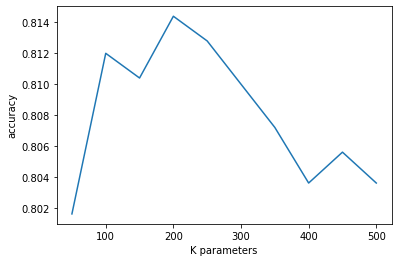

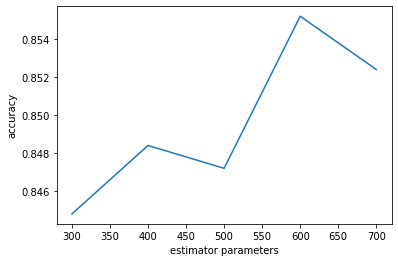

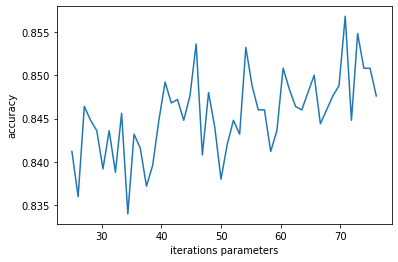

In [ ]:
plot_all_tunning_parameters(estimators, accuracies)

# Use Data without Pre-processing

In [ ]:
x_train,y_train = train_withoutPre['review'].copy(),train_withoutPre['class'].copy()
x_test,y_test = test_withoutPre['review'].copy(),test_withoutPre['class'].copy()
x_val,y_val = val_withoutPre['review'].copy(),val_withoutPre['class'].copy()

In [ ]:
vec_withoutPre = vectorize(x_train)
x_train =  vec_withoutPre.transform(x_train)
x_test = vec_withoutPre.transform(x_test)
x_val =  vec_withoutPre.transform(x_val)
num_without = x_train.shape[1];

In [ ]:
# k, estimator, depth = tune_all(x_train,y_train, x_val, y_val)
vectorized_acc_withoutPre = classify_all(x_train, y_train,x_test, y_test , k=k, estimator= estimator, max_depth=depth)

In [ ]:
print_all("Classify data without pre-processing using TF-IDF feature vectorize", vectorized_acc_withoutPre)

Classify data without pre-processing using TF-IDF feature vectorize
 KNN - accuracy =  0.742
 AdaBoost - accuracy =  0.84312
 RandomForest - accuracy =  0.81648
 LinearSVC - accuracy =  0.8436
 LogisticRegression - accuracy =  0.8746


## Pre-processing effect

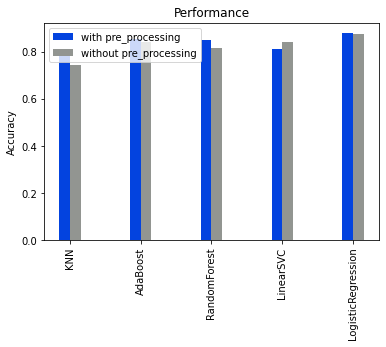

In [ ]:
plot_accuracy(vectorized_acc, vectorized_acc_withoutPre)

The accuracy didn't improve much with pre-processing

## Features choice

No handles with labels found to put in legend.


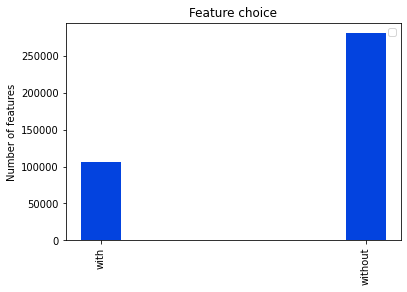

In [ ]:
plot_features(num, num_without)

In [ ]:
print("pre_processed data features :",num)
print("Not pre_processed data features :",num_without)


pre_processed data features : 105852
Not pre_processed data features : 280617


Number of features with pre-processing is much lower than without pre-processing 

## Failure cases

- Tried to implement the Nive Bayes classifier but it requires to convert the sparce array to dense array and this make the data very big and the memory crashes


______________________________________________________________________________________________________

#**Second Apply Machine Learning using word embedding - Gensim library**


## Use Pre-processed data

In [ ]:
# change the data formating and create the Data matrix
x_train,y_train = change_format_embedded(train)
x_test,y_test = change_format_embedded(test)
x_val,y_val = change_format_embedded(val)

In [ ]:
# get the required data structure to start modeling
train_corpus = list(convert_corpus(x_train))

# Train Doc2Vec model
model = doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
x_train, y_train = create_embedded_matrix(x_train, y_train)
x_test, y_test = create_embedded_matrix(x_test, y_test)
x_val,y_val = create_embedded_matrix(x_val,y_val)
num = len(x_train[0])

In [ ]:
# k, estimator, depth = tune_all(x_train,y_train, x_val, y_val)
embedded_accuracy = classify_all(x_train, y_train,x_test, y_test)

In [ ]:
print_all("Classification using Text with Pre-processing", embedded_accuracy)

Classification using Text with Pre-processing
 KNN - accuracy =  0.77832
 AdaBoost - accuracy =  0.78952
 RandomForest - accuracy =  0.77912
 LinearSVC - accuracy =  0.80628
 LogisticRegression - accuracy =  0.80556


# Use Data without Pre-processing

In [ ]:
# change the data formating and create the Data matrix
x_train,y_train = change_format_embedded(train_withoutPre)
x_test,y_test = change_format_embedded(test_withoutPre)
x_val,y_val = change_format_embedded(val_withoutPre)

In [ ]:
# get the required data structure to start modeling
train_corpus = list(convert_corpus(x_train))

# Train Doc2Vec model
model = doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
x_train, y_train = create_embedded_matrix(x_train, y_train)
x_test, y_test = create_embedded_matrix(x_test, y_test)
x_val,y_val = create_embedded_matrix(x_val,y_val)
num_without = len(x_train[0])

In [ ]:
# k, estimator, depth = tune_all(x_train,y_train, x_val, y_val)
embedded_accuracy_withoutPre = classify_all(x_train, y_train,x_test, y_test)

In [ ]:
print_all("Classification using Text with Pre-processing", embedded_accuracy_withoutPre)

Classification using Text with Pre-processing
 KNN - accuracy =  0.5936
 AdaBoost - accuracy =  0.61972
 RandomForest - accuracy =  0.61532
 LinearSVC - accuracy =  0.63432
 LogisticRegression - accuracy =  0.63416


## Pre-processing effect

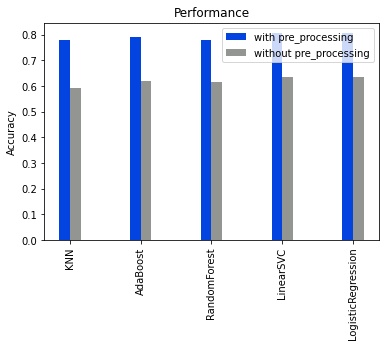

In [ ]:
plot_accuracy(embedded_accuracy, embedded_accuracy_withoutPre)

## pre-processing improve the accuracy with observable value.

## Features choice

No handles with labels found to put in legend.


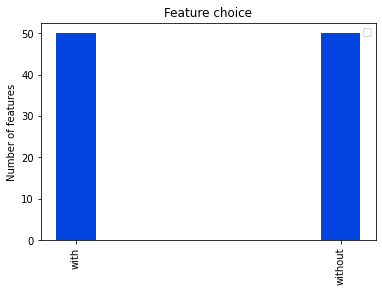

In [ ]:
plot_features(num, num_without)

In [ ]:
print("pre_processed data features :",num)
print("Not pre_processed data features :",num_without)


pre_processed data features : 50
Not pre_processed data features : 50


First Tried to train the model with vector_size = 50.
And tried to do the previous steps with vector_size = 150.
But the resulting accuracy didn’t improve with observable value.

Besides it take nearly twice the time to convert the data to the wanted data matrix, So it was decided that the vector size will be 50.
